# Análisis del comportamiento de usuarios y evaluación de test A/A/B 
### **Daniel Ramírez Martínez** 19-06-2025


# Objetivos

1. **Embudo de conversión** – detectar dónde abandonan los usuarios.  
2. **Experimento A/A/B** – evaluar si la nueva fuente (grupo B) afecta el comportamiento.  


# Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


# Datos 

In [2]:
# Cargar los datos
df = pd.read_csv('/datasets/logs_exp_us.csv')

# Vista general
df.head()
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 1 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   EventName	DeviceIDHash	EventTimestamp	ExpId  244126 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


,EventName\tDeviceIDHash\tEventTimestamp\tExpId
count,244126
unique,243713
top,PaymentScreenSuccessful\t4980045449118619005\t...
freq,5


## Revición de las primeras filas y el número de columnas


In [3]:
print(df.head())
print(df.columns)
print(df.shape)



      EventName\tDeviceIDHash\tEventTimestamp\tExpId
0  MainScreenAppear\t4575588528974610257\t1564029...
1  MainScreenAppear\t7416695313311560658\t1564053...
2  PaymentScreenSuccessful\t3518123091307005509\t...
3  CartScreenAppear\t3518123091307005509\t1564054...
4  PaymentScreenSuccessful\t6217807653094995999\t...
Index(['EventName\tDeviceIDHash\tEventTimestamp\tExpId'], dtype='object')
(244126, 1)


## Nota

Todas las columnas están combinadas en una sola, separadas por \t (tabulaciones). Esto sucede porque el archivo usa delimitador de tabulación

## Preparación de los datos 

In [4]:
# Cargar el archivo con el delimitador correcto (tabulador)
df = pd.read_csv('/datasets/logs_exp_us.csv', delimiter='\t')

# Verificar las primeras filas
print("Primeras filas del dataset:")
print(df.head())

# Renombrar las columnas para mayor comodidad
df.columns = ['event', 'user_id', 'timestamp', 'exp_id']

# Convertir timestamp a formato datetime (formato UNIX)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Crear columnas adicionales: fecha y hora
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# Verificar que las transformaciones hayan sido exitosas
print("\nColumnas del dataframe:")
print(df.columns)
print("\nTipos de datos:")
print(df.dtypes)

Primeras filas del dataset:
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

Columnas del dataframe:
Index(['event', 'user_id', 'timestamp', 'exp_id', 'date', 'hour'], dtype='object')

Tipos de datos:
event                object
user_id               int64
timestamp    datetime64[ns]
exp_id                int64
date                 object
hour                  int64
dtype: object


<div class="alert alert-block alert-success">
<b>Celda [4]</b> <a class="tocSkip"></a><br>
Has realizado correctamente la conversión de <code>timestamp</code> a formato <code>datetime</code>. 
</div>


## Explorar datos generales 

In [5]:
total_events   = len(df)
unique_users   = df['user_id'].nunique()
events_per_usr = df.groupby('user_id').size().mean()

print(f"Eventos totales      : {total_events}")
print(f"Usuarios únicos      : {unique_users}")
print(f"Eventos promedio/USR : {events_per_usr:.2f}")
print("Periodo              :", df['timestamp'].min(), "→", df['timestamp'].max())


Eventos totales      : 244126
Usuarios únicos      : 7551
Eventos promedio/USR : 32.33
Periodo              : 2019-07-25 04:43:36 → 2019-08-07 21:15:17


# Evaluar completitud temporal



## Histograma de eventos por día

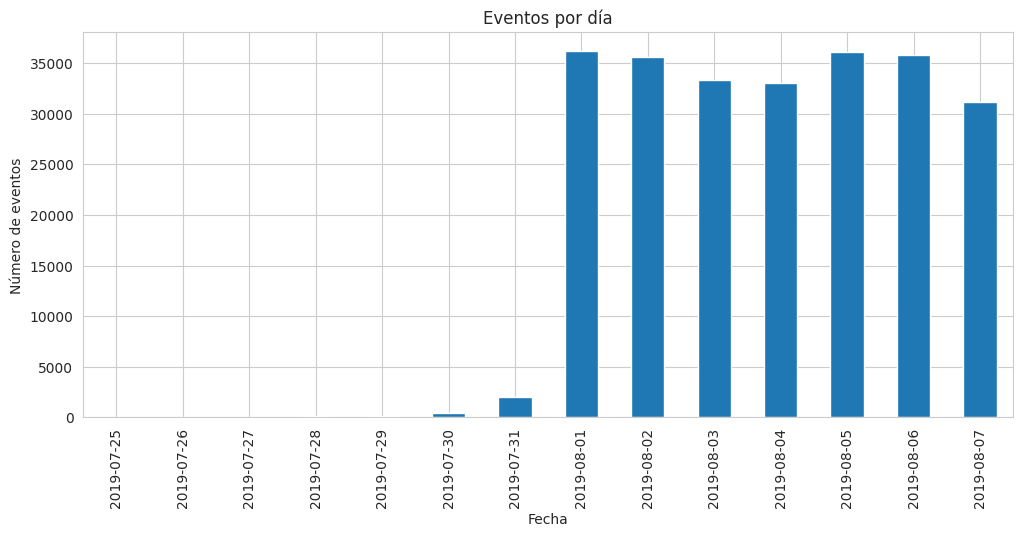

In [6]:

plt.figure(figsize=(12,5))
df.groupby('date').size().plot(kind='bar')
plt.title('Eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.show()


## Interpretación


No hay registros del periodo 2019-07-25 a 2019-07-29, comienzan a registrase eventos a partir del 2019-07-30. Por lo que podriamos prescindir sin esto datos para evitar sesgos. 

## Eliminar registros del periodo 25-07-2019 a 29-07-2019 

In [7]:
df = df[df['timestamp'] >= '2019-07-30']


<div class="alert alert-success">
<b>Celda [7]</b> <a class="tocSkip"></a><br>
Has filtrado los datos a partir de una fecha específica. 
</div>


## Evaluar usuarios y eventos perdidos

In [8]:
filtered_users = df['user_id'].nunique()
filtered_events = len(df)
print(f"Usuarios tras filtrado: {filtered_users} (extraídos: {unique_users - filtered_users})")
print(f"Eventos tras filtrado: {filtered_events} (extraídos: {total_events - filtered_events})")


Usuarios tras filtrado: 7547 (extraídos: 4)
Eventos tras filtrado: 243742 (extraídos: 384)


# Verificar grupos experimentales

In [9]:
df['exp_id'].value_counts()


248    85619
246    80174
247    77949
Name: exp_id, dtype: int64

# Análisis del embudo de conversión

## Contar eventos y usuarios por evento

In [10]:
event_counts = df['event'].value_counts()
users_per_event = df.groupby('event')['user_id'].nunique()

event_summary = pd.DataFrame({
    'event_count': event_counts,
    'unique_users': users_per_event
})
event_summary['prop_users'] = event_summary['unique_users'] / df['user_id'].nunique()
event_summary.sort_values(by='event_count', ascending=False)


,event_count,unique_users,prop_users
MainScreenAppear,118961,7435,0.985160
OffersScreenAppear,46775,4612,0.611104
CartScreenAppear,42672,3747,0.496489
PaymentScreenSuccessful,34286,3546,0.469856
Tutorial,1048,845,0.111965


### Gráfico: Embudo de conversión – Usuarios únicos

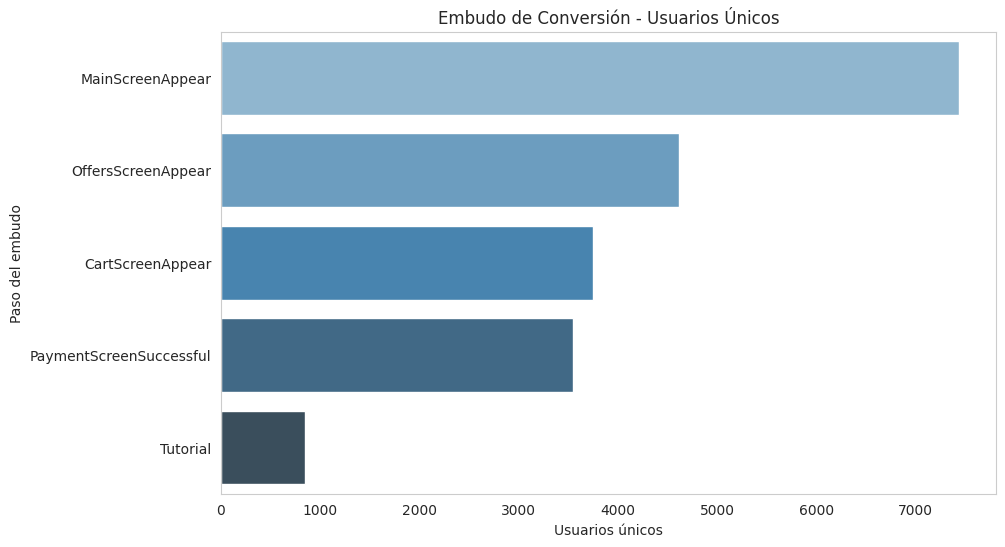

In [11]:

# Lista de pasos del embudo
steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful','Tutorial']
funnel_counts = [len(df[df['event'] == step]['user_id'].unique()) for step in steps]

# Gráfico tipo embudo (barras horizontales)
plt.figure(figsize=(10, 6))
sns.barplot(x=funnel_counts, y=steps, palette="Blues_d")
plt.title('Embudo de Conversión - Usuarios Únicos')
plt.xlabel('Usuarios únicos')
plt.ylabel('Paso del embudo')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


#### Interpretación 

- MainScreenAppear
118,961 eventos → muchas visitas repetidas.
7,435 usuarios únicos → casi todos los usuarios del experimento (98.5%) la vieron.

👉 Es el punto de entrada principal al flujo.

- OffersScreenAppear
46,775 eventos con 4,612 usuarios únicos → alrededor del 61.1% de los usuarios llegaron aquí.

👉 Hay cierta caída desde la pantalla principal, pero más de la mitad avanza.

- CartScreenAppear
42,672 eventos, 3,747 usuarios únicos → el 49.6% llega al carrito.

👉 Aún hay una conversión aceptable desde "Offers", pero con pérdida acumulada.

- PaymentScreenSuccessful
34,286 eventos, 3,546 usuarios únicos → el 46.9% del total logra completar el pago.

👉 Muy cerca del número de usuarios del carrito → alta conversión entre carrito y pago.

- Tutorial
Solo 1,048 eventos y 845 usuarios únicos → solo el 11.2% de los usuarios lo vieron.

👉 El tutorial no parece ser parte del flujo estándar, o solo se muestra a ciertos usuarios (nuevos).

## Definir el embudo
MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful

In [12]:
# Definir pasos
steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Crear un diccionario con usuarios únicos por evento
users_steps = {step: set(df[df['event'] == step]['user_id']) for step in steps}

print("Proporciones de usuarios que pasan de un paso al siguiente:")

for i in range(len(steps)-1):
    a, b = steps[i], steps[i+1]
    users_a = users_steps.get(a, set())
    users_b = users_steps.get(b, set())

    if len(users_a) == 0:
        print(f" No hay usuarios en {a}, no se puede calcular la proporción hacia {b}.")
    else:
        prop = len(users_a & users_b) / len(users_a)
        print(f"De {a} → {b}: {prop:.2%} ({len(users_a & users_b)} de {len(users_a)} usuarios)")

# Proporción general desde el primer paso hasta la conversión final
users_inicio = users_steps.get(steps[0], set())
users_final = users_steps.get(steps[-1], set())

if len(users_inicio) == 0:
    print("\n No se puede calcular la proporción total: no hay usuarios en el primer paso.")
else:
    prop_total = len(users_inicio & users_final) / len(users_inicio)
    print(f"\n Proporción total de conversión: {prop_total:.2%} ({len(users_inicio & users_final)} de {len(users_inicio)} usuarios)")


Proporciones de usuarios que pasan de un paso al siguiente:
De MainScreenAppear → OffersScreenAppear: 60.58% (4504 de 7435 usuarios)
De OffersScreenAppear → CartScreenAppear: 79.97% (3688 de 4612 usuarios)
De CartScreenAppear → PaymentScreenSuccessful: 94.53% (3542 de 3747 usuarios)

 Proporción total de conversión: 46.42% (3451 de 7435 usuarios)


## Gráfico de embudo de conversion de usuarios 

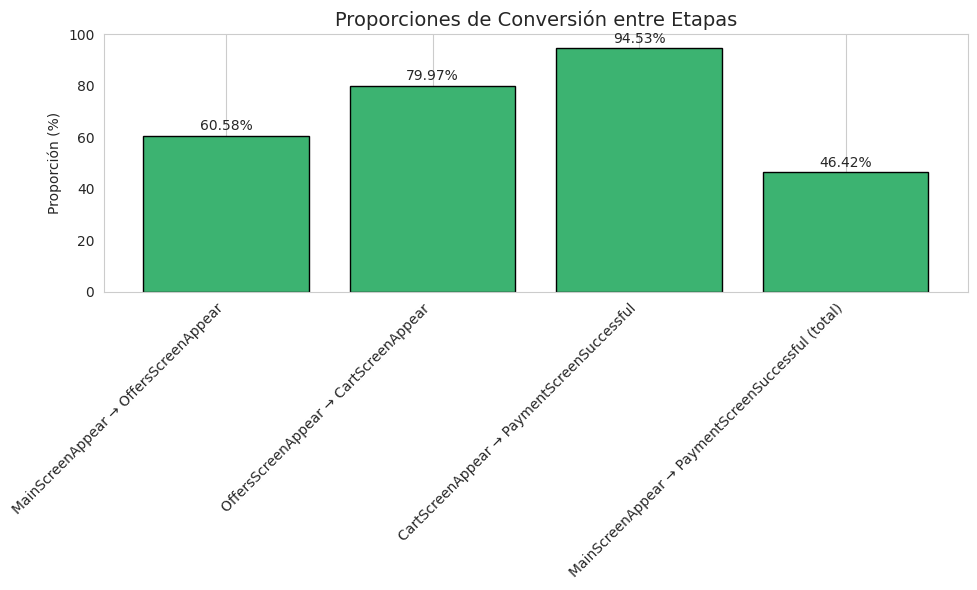

In [13]:

# Definir pasos
steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Crear diccionario con sets de usuarios por paso
users_steps = {step: set(df[df['event'] == step]['user_id']) for step in steps}

# Calcular proporciones entre pasos
conversion_labels = []
conversion_rates = []

for i in range(len(steps)-1):
    a, b = steps[i], steps[i+1]
    users_a = users_steps.get(a, set())
    users_b = users_steps.get(b, set())
    
    if len(users_a) == 0:
        continue
    prop = len(users_a & users_b) / len(users_a)
    label = f"{a} → {b}"
    conversion_labels.append(label)
    conversion_rates.append(round(prop * 100, 2))  # porcentaje

# Agregar proporción general
users_inicio = users_steps.get(steps[0], set())
users_final = users_steps.get(steps[-1], set())
if len(users_inicio) > 0:
    prop_total = len(users_inicio & users_final) / len(users_inicio)
    conversion_labels.append("MainScreenAppear → PaymentScreenSuccessful (total)")
    conversion_rates.append(round(prop_total * 100, 2))

# Crear gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(conversion_labels, conversion_rates, color='mediumseagreen', edgecolor='black')

# Etiquetas
plt.title("Proporciones de Conversión entre Etapas", fontsize=14)
plt.ylabel("Proporción (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Añadir valores encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 1,
             f"{height:.2f}%",
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Interpretación

1. Del paso "MainScreenAppear" a "OffersScreenAppear", el 60.58% de los usuarios continúa su navegación. Este primer descenso sugiere una posible área de mejora en el diseño o atractivo de la pantalla principal para motivar al usuario a explorar más ofertas.

2. Entre "OffersScreenAppear" y "CartScreenAppear", el 79.97% de los usuarios que visualizan ofertas agregan productos al carrito, lo cual indica una alta intención de compra en esta etapa.

3. Desde "CartScreenAppear" a "PaymentScreenSuccessful", se mantiene una excelente conversión del 94.53%, lo cual indica que una vez los usuarios deciden comprar, el proceso de pago es eficiente y libre de fricciones.

4. La proporción total de conversión desde que los usuarios ven la pantalla principal hasta que completan una compra es del 46.42%, es decir, casi 1 de cada 2 usuarios que inician el flujo lo completan con éxito.

# Evaluación A/A/B

## Cantidad de usuarios por grupo 

In [14]:
group_users = df.groupby('exp_id')['user_id'].nunique()
group_users


exp_id
246    2487
247    2520
248    2540
Name: user_id, dtype: int64

## Prueba de diferencias entre los dos controles (246 vs 247)
Test de proporciones 

In [15]:

def proportion_test(event, g1, g2):
    u1 = df[(df['exp_id']==g1) & (df['event']==event)]['user_id'].nunique()
    u2 = df[(df['exp_id']==g2) & (df['event']==event)]['user_id'].nunique()
    n1 = df[df['exp_id']==g1]['user_id'].nunique()
    n2 = df[df['exp_id']==g2]['user_id'].nunique()
    stat, p = proportions_ztest([u1,u2], [n1,n2])
    return event, p

events = df['event'].unique()
results_aa = [proportion_test(ev, 246, 247) for ev in events]
sorted(results_aa, key=lambda x: x[1])[:5]  # los eventos con menor p‑valor


[('PaymentScreenSuccessful', 0.10315346318364041),
 ('CartScreenAppear', 0.19806289961406698),
 ('OffersScreenAppear', 0.2925296530723157),
 ('MainScreenAppear', 0.5880098694892003),
 ('Tutorial', 0.8830102160335023)]

## Grafico 

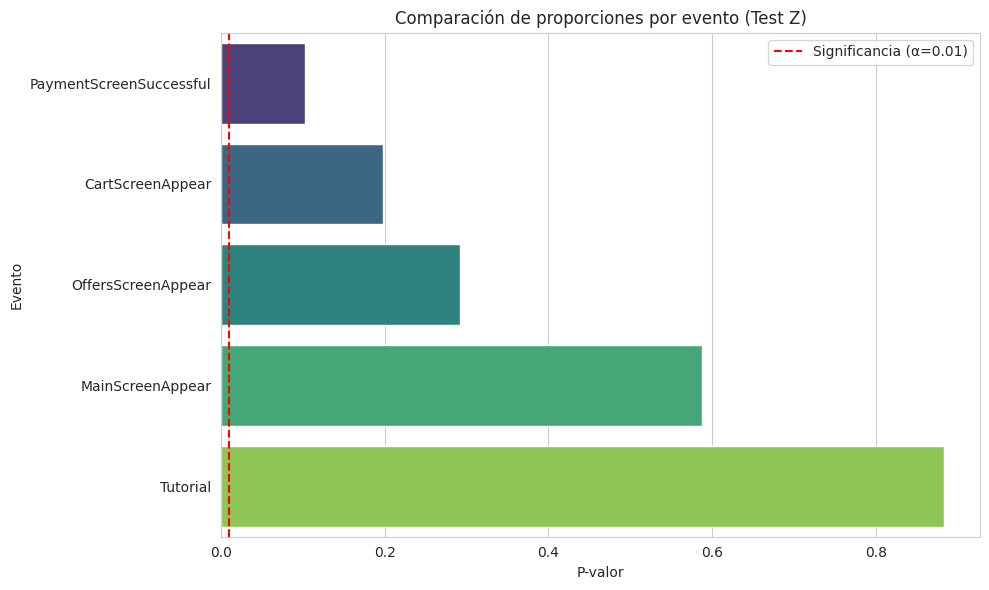

In [16]:
# Convertir resultados a DataFrame
results_df = pd.DataFrame(results_aa, columns=['event', 'p_value'])
results_df = results_df.sort_values('p_value')

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='p_value', y='event', palette='viridis')

# Línea de corte para significancia (por ejemplo, Bonferroni para 5 pruebas: 0.05/5 = 0.01)
plt.axvline(0.01, color='red', linestyle='--', label='Significancia (α=0.01)')

plt.xlabel('P-valor')
plt.ylabel('Evento')
plt.title('Comparación de proporciones por evento (Test Z)')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretación

- Ningún valor p está por debajo de 0.05, por lo tanto:

No hay diferencias estadísticamente significativas entre los grupos 246 y 247 para ninguno de los eventos del embudo.

El test A/A valida que el sistema de experimentación es estable: los grupos son equivalentes y no hay sesgo oculto.

El evento PaymentScreenSuccessful es el más cercano a ser significativo, pero aún no lo es. Podría ser relevante en un futuro A/B test si se repite esta tendencia.

## Comparar grupo B (248) contra A (246+247)

In [17]:
df['group'] = df['exp_id'].apply(lambda x: 'A' if x in [246,247] else 'B')

def test_A_vs_B(event):
    uA = df[(df['group']=='A') & (df['event']==event)]['user_id'].nunique()
    uB = df[(df['group']=='B') & (df['event']==event)]['user_id'].nunique()
    nA = df[df['group']=='A']['user_id'].nunique()
    nB = df[df['group']=='B']['user_id'].nunique()
    stat, p = proportions_ztest([uA,uB], [nA,nB])
    return event, p

results_ab = [test_A_vs_B(ev) for ev in events]
sorted(results_ab, key=lambda x: x[1])[:5]


[('CartScreenAppear', 0.2607772485768062),
 ('OffersScreenAppear', 0.47786131391128683),
 ('MainScreenAppear', 0.5054345060564138),
 ('PaymentScreenSuccessful', 0.6452110591775255),
 ('Tutorial', 0.8534426570455924)]

## Grafico 

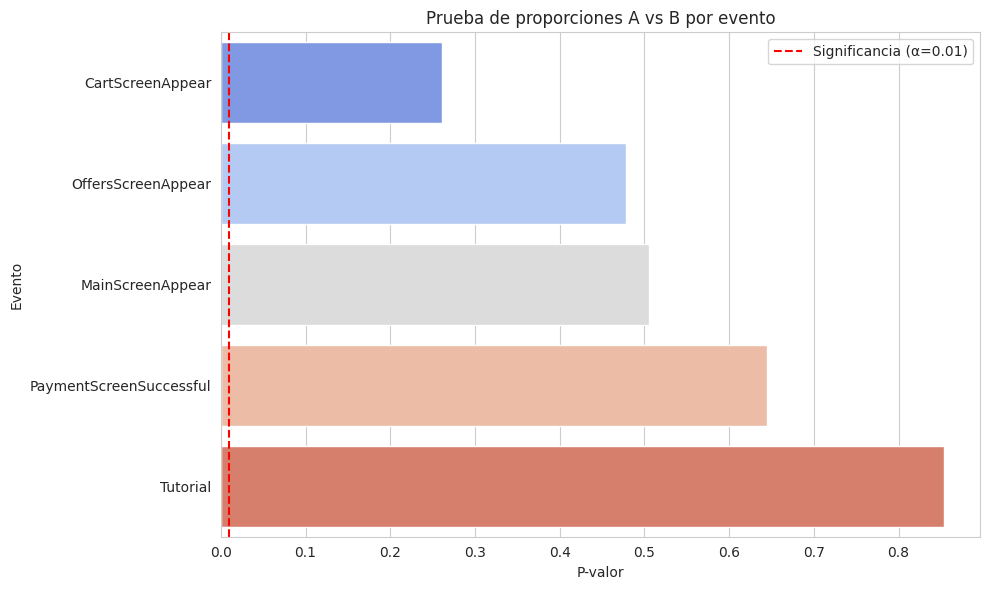

In [18]:
# Convertir resultados a DataFrame
results_ab_df = pd.DataFrame(results_ab, columns=['event', 'p_value'])
results_ab_df = results_ab_df.sort_values('p_value')

# Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=results_ab_df, x='p_value', y='event', palette='coolwarm')

# Línea de corte para significancia estadística (Bonferroni si hay muchas pruebas)
plt.axvline(0.01, color='red', linestyle='--', label='Significancia (α=0.01)')

plt.xlabel('P-valor')
plt.ylabel('Evento')
plt.title('Prueba de proporciones A vs B por evento')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretación

Todos los valores p son mayores a 0.05, lo que indica que:

No hay evidencia estadística suficiente para afirmar que los grupos A y B se comportan distinto en ninguno de los pasos del embudo.

Esto sugiere que el cambio aplicado en el grupo B (si hubo alguno) no produjo un efecto significativo en el comportamiento de los usuarios.

Este tipo de resultado es útil: confirma que, hasta ahora, el nuevo experimento (grupo B) no afecta negativamente ni mejora el comportamiento de conversión respecto al control.



# Ajuste por comparaciones múltiples

In [19]:
num_tests = len(events)
alpha = 0.05
bonferroni = alpha / num_tests
print(f"Nivel ajustado Bonferroni: {bonferroni:.4f}")


Nivel ajustado Bonferroni: 0.0100


Gráfico de barras de p-valores (con línea Bonferroni)

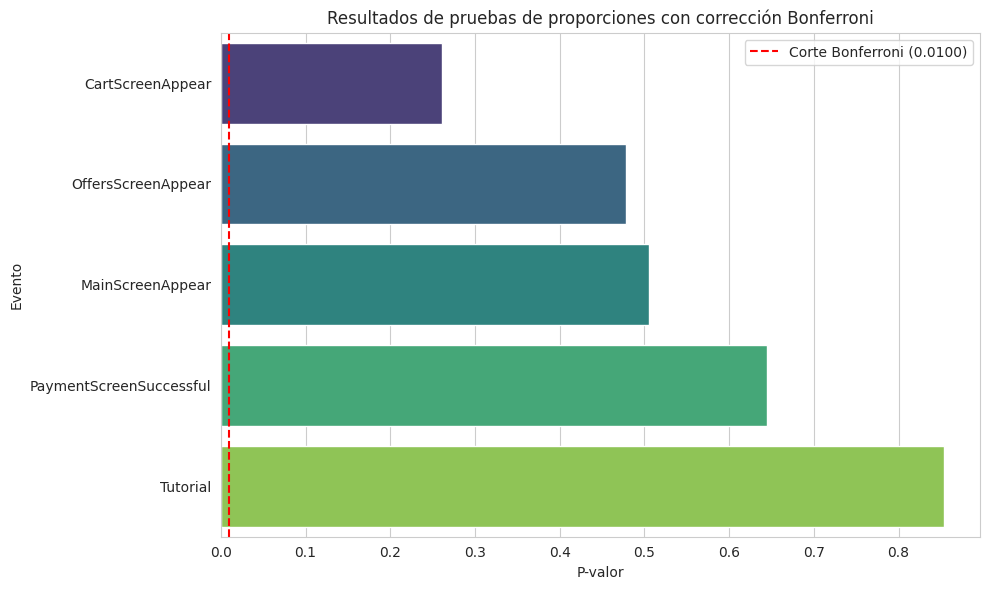

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_ab_df, x='p_value', y='event', palette='viridis')

# Línea de corte Bonferroni
plt.axvline(bonferroni, color='red', linestyle='--', label=f'Corte Bonferroni ({bonferroni:.4f})')

plt.xlabel('P-valor')
plt.ylabel('Evento')
plt.title('Resultados de pruebas de proporciones con corrección Bonferroni')
plt.legend()
plt.tight_layout()
plt.show()


### Interpretación

Según los resultados de las pruebas de proporciones, no se observaron diferencias estadísticamente significativas en la conversión por evento entre los grupos A y B. Esto sugiere que la variante evaluada no tuvo un impacto medible sobre el comportamiento de los usuarios dentro del embudo de conversión.

### Tabla con los valores de las pruebas

In [21]:
# Convertir los resultados en DataFrame
results_ab_df = pd.DataFrame(results_ab, columns=['event', 'p_value'])

# Calcular el valor Bonferroni
num_tests = len(results_ab_df)
alpha = 0.05
bonferroni = alpha / num_tests

# Agregar columna de significancia
results_ab_df['significativo_bonferroni'] = results_ab_df['p_value'] < bonferroni

# Opcional: ordenar por p-valor para mejor visualización
results_ab_df = results_ab_df.sort_values('p_value').reset_index(drop=True)

# Mostrar tabla
print(f"Nivel ajustado Bonferroni: {bonferroni:.4f}")
display(results_ab_df)

Nivel ajustado Bonferroni: 0.0100


,event,p_value,significativo_bonferroni
0,CartScreenAppear,0.260777,False
1,OffersScreenAppear,0.477861,False
2,MainScreenAppear,0.505435,False
3,PaymentScreenSuccessful,0.645211,False
4,Tutorial,0.853443,False


# Conclusiones

- Ningún evento mostró diferencias estadísticamente significativas entre los grupos A (246 y 247) y B (248), incluso después de aplicar la corrección Bonferroni.

- Los valores p están todos muy por encima del umbral ajustado Bonferroni (0.01 si tienes 5 eventos y α=0.05), lo que refuerza que no hay evidencia para rechazar la hipótesis nula.

- En términos simples:
el grupo experimental y el de control se comportaron igual en todos los pasos del embudo.